Net with different likelihood for test

In [1]:
import tensorflow_probability as tfp
import tensorflow as tf

from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

from importlib import reload

In [2]:
import sys
import os
sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE.layers as layers
from tools_for_VAE import utils, vae_functions, generator, model

In [3]:
reload(utils)

<module 'tools_for_VAE.utils' from '../../scripts/tools_for_VAE/tools_for_VAE/utils.py'>

In [4]:
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, Reshape, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, Flatten,  Reshape, UpSampling2D, Cropping2D, Conv2DTranspose, PReLU, Concatenate, Lambda, BatchNormalization, concatenate, LeakyReLU

In [5]:
tfd = tfp.distributions

In [6]:
import tensorflow

# Parameters

In [7]:
nb_of_bands = 6
batch_size = 100 

input_shape = (64, 64, nb_of_bands)
hidden_dim = 256
latent_dim = 32
final_dim = 2
filters = [32, 64, 128, 256]
kernels = [3,3,3,3]

conv_activation = None
dense_activation = None

bands = [4,5,6,7,8,9]

# Data loading

## Batchgenerator

In [8]:
images_dir = '/sps/lsst/users/barcelin/data/TFP/GalSim_COSMOS/isolated_galaxies/centered/'
list_of_samples = [x for x in utils.listdir_fullpath(os.path.join(images_dir,'test')) if x.endswith('.npy')]
list_of_samples_val = [x for x in utils.listdir_fullpath(os.path.join(images_dir,'validation')) if x.endswith('.npy')]

In [10]:
test_generator = generator.BatchGenerator(bands, list_of_samples, total_sample_size=None,
                                    batch_size=batch_size, 
                                    trainval_or_test='training',
                                    do_norm=True,
                                    denorm = False,
                                    list_of_weights_e=None)


[BatchGenerator] total_sample_size =  10000
[BatchGenerator] len(list_of_samples) =  1


# Model avec latent space

## Different likelihood

In [13]:
lik_fn = []

### gaussian mixture

In [14]:
### Added for gaussian mixture
num_mix_components = 5
def make_gaussian_mixture(acts):
    acts = tf.convert_to_tensor(acts)
    logits, mu, sigma = tf.split(acts, 3, axis=-1)
    cat = tfd.Categorical(logits=logits)
    mixture = tfd.MixtureSameFamily(mixture_distribution=cat, 
                                    components_distribution=tfd.Normal(loc=mu, scale=1e-5 + sigma), 
                                    reparameterize=False)

    return mixture
setattr(make_gaussian_mixture, 'num_activations', num_mix_components * 3)
lik_fn.append(make_gaussian_mixture)

### Multivariate TriL gaussian

In [15]:
def make_multivariatetril(acts):
    mu_length = 2 # 2 for e1 and e2, 1 for e1 only
    print(mu_length)
    num_act = (mu_length*3 + (mu_length)**2)/2
    print(num_act)

    acts = tf.convert_to_tensor(acts)
    if mu_length == 1 :
        mu, covariance = tf.split(acts,[1, 1], axis=-1)
    else:
        mu, covariance = tf.split(acts,[int(mu_length), int(num_act)-int(mu_length)], axis=-1)
    multivariatetril = tfd.MultivariateNormalTriL(loc=mu, scale_tril=covariance)

    return multivariatetril

mu_length_tril = 2 # 2 for e1 and e2, 1 for e1 only
num_act_tril = (mu_length_tril*3 + (mu_length_tril)**2)/2
setattr(make_multivariatetril, 'num_activations', num_act_tril)
lik_fn.append(make_multivariatetril)

### Multivariate Full Covariance gaussian

In [16]:
def make_multivariatefullcov(acts):
    mu_length = 1 # 2 for e1 and e2, 1 for e1 only
    print(mu_length)
    num_act = (mu_length)**2
    print(num_act)
    acts = tf.convert_to_tensor(acts)
    if mu_length == 1 :
        mu, cov = tf.split(acts,[1, 1], axis=-1)
    else:
        mu, cov = tf.split(acts, [int(mu_length), int(num_act)-int(mu_length)+1], axis=-1)
    multivariatefullcov = tfd.MultivariateNormalFullCovariance(loc=mu, covariance_matrix=cov)

    return multivariatefullcov

mu_length_full = 1 # 2 for e1 and e2, 1 for e1 only
num_act_full = (mu_length_full*3 + (mu_length_full)**2)/2
setattr(make_multivariatefullcov, 'num_activations', num_act_full)
lik_fn.append(make_multivariatefullcov)

In [17]:
lik_fn[0]

<function __main__.make_gaussian_mixture(acts)>

In [18]:
print(lik_fn)

[<function make_gaussian_mixture at 0x7fb2b9120950>, <function make_multivariatetril at 0x7fb2b91209d8>, <function make_multivariatefullcov at 0x7fb2b9120730>]


## Model

In [19]:
lik_fn_nb = 2 # rank of likelihood function wanted

In [20]:
latent_dim = 10

tfd = tfp.distributions
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dim), scale=1),
                        reinterpreted_batch_ndims=1)

final_dim = 1

prior_output = tfd.Independent(tfd.Normal(loc=tf.zeros(final_dim), scale=1),
                        reinterpreted_batch_ndims=1)

input_layer = Input(shape=((64,64,nb_of_bands)))  

h = Reshape((64,64,nb_of_bands))(input_layer)
h = BatchNormalization()(h)
for i in range(len(filters)):
    h = Conv2D(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same')(h)
    h = PReLU()(h)
    h = Conv2D(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same', strides=(2,2))(h)
    h = PReLU()(h)
h = Flatten()(h)
h = Dense(tfp.layers.MultivariateNormalTriL.params_size(latent_dim),
            activation=None)(h)
h = tfp.layers.MultivariateNormalTriL(
        latent_dim,
        activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=0.01))(h)


h = Flatten()(h)
h = tf.keras.layers.Dense(512, activation=None)(h)
h = tf.keras.layers.PReLU()(h)
h = tf.keras.layers.Dense(192, activation=None)(h)
h = tf.keras.layers.PReLU()(h)

# For changing likelihood
#h = tf.keras.layers.Dense(lik_fn[lik_fn_nb].num_activations, activation='relu')(h)
print(h)
print(lik_fn[lik_fn_nb])
#h_1 = tfp.layers.DistributionLambda(lik_fn[lik_fn_nb])(h)
#h_2 = tfp.layers.DistributionLambda(lik_fn[lik_fn_nb])(h)

# Multivariate gaussian
h = tf.keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(final_dim),activation='relu')(h)
h_1 = tfp.layers.MultivariateNormalTriL(final_dim)(h)#, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior_output, weight=0.001))(h)

model = Model(input_layer,h_1)#[h_1,h_2])

Tensor("p_re_lu_9/Identity:0", shape=(None, 192), dtype=float32)
<function make_multivariatefullcov at 0x7fb2b9120730>


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 6)]       0         
_________________________________________________________________
reshape (Reshape)            (None, 64, 64, 6)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 6)         24        
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        1760      
_________________________________________________________________
p_re_lu (PReLU)              (None, 64, 64, 32)        131072    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 32, 32, 32)        32768 

In [22]:
#net = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]))

In [23]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

def nll(x, dists):
    return -dists.log_prob(x)

In [24]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), 
              loss=negative_log_likelihood , metrics = ['mse'])#negative_log_likelihood#tf.keras.losses.MSE

In [29]:
%load_ext tensorboard

import datetime, os

In [30]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Training model

In [31]:
# hist = model.fit_generator(generator = test_generator, epochs=10,
#           steps_per_epoch=16,#128
#           verbose=1,
#           shuffle=True,
#           validation_data=test_generator,
#           validation_steps=2,#16
#           workers=0,#4 
#           use_multiprocessing = True,
#           callbacks=[tensorboard_callback])

In [25]:
#loading_path = '/sps/lsst/users/barcelin/TFP/weights/test_1/'# Gaussian mixture
#loading_path = '/sps/lsst/users/barcelin/TFP/weights/test_2/'# Multivariate tril
loading_path = '/sps/lsst/users/barcelin/TFP/weights/test_3/'# Multivariate full cov

In [32]:
latest = tf.train.latest_checkpoint(loading_path)
model.load_weights(latest)

In [ ]:
######## Train the network
hist = model.fit(training_data, training_labels, epochs=20,
          steps_per_epoch=10,#128
          verbose=1,
          shuffle=True,
          validation_data=(validation_data,validation_labels),
          validation_steps=2,#16
          workers=0,#4 
          use_multiprocessing = True)

Train on 1000 samples, validate on 500 samples
Epoch 1/20
1000/1000 [==============================] - 4s 4ms/sample - loss: 1.0513 - mse: 0.9320 - val_loss: 0.4367 - val_mse: 0.8905
Epoch 2/20
1000/1000 [==============================] - 4s 4ms/sample - loss: 1.0079 - mse: 0.9144 - val_loss: 0.4468 - val_mse: 0.9833
Epoch 3/20
1000/1000 [==============================] - 4s 4ms/sample - loss: 1.0192 - mse: 0.8687 - val_loss: 0.4447 - val_mse: 0.9225
Epoch 4/20
1000/1000 [==============================] - 4s 4ms/sample - loss: 1.0098 - mse: 0.9066 - val_loss: 0.4438 - val_mse: 0.9031
Epoch 5/20
1000/1000 [==============================] - 4s 4ms/sample - loss: 1.0330 - mse: 0.8248 - val_loss: 0.4355 - val_mse: 0.8310
Epoch 6/20
1000/1000 [==============================] - 4s 4ms/sample - loss: 1.0096 - mse: 0.7794 - val_loss: 0.4423 - val_mse: 1.0653
Epoch 7/20
1000/1000 [==============================] - 4s 4ms/sample - loss: 1.0040 - mse: 0.8304 - val_loss: 0.4438 - val_mse: 0.9541
E

In [ ]:
model.save_weights(loading_path+'cp-{epoch:04d}.ckpt')

# Loading weights

In [ ]:
out = model(validation_data)

In [ ]:
sns.distplot(out.mean().numpy()[:], bins = 20)
sns.distplot(validation_labels, bins = 20)

In [52]:
sns.distplot(test[1][:,0], bins = 20)

IndexError: too many indices for array

In [ ]:
plt.plot(test[1][:], out[:].numpy(), 'o')
x = np.linspace(0,4)
plt.plot(x, x)

In [312]:
out[0,0]

InvalidArgumentError: Index out of range using input dim 1; input has only 1 dims [Op:StridedSlice] name: strided_slice/

In [313]:
out[:,0].numpy().shape

InvalidArgumentError: Index out of range using input dim 1; input has only 1 dims [Op:StridedSlice] name: strided_slice/

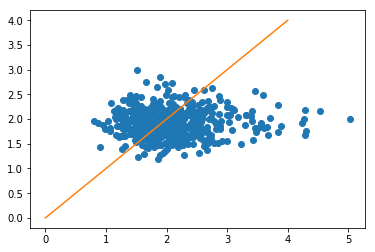

In [32]:
plt.plot(validation_labels, out.mean().numpy()[:], 'o')
x = np.linspace(0,4)
plt.plot(x, x)

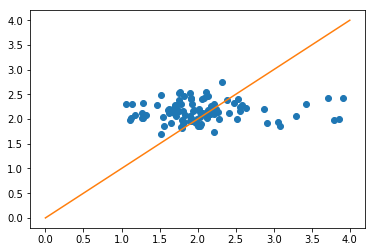

In [315]:
plt.plot(test[1][:], out.mean().numpy()[:], 'o')
x = np.linspace(0,4)
plt.plot(x, x)

One sampling for 100 images (one batch)

Text(0.5, 1.0, '$e1$')

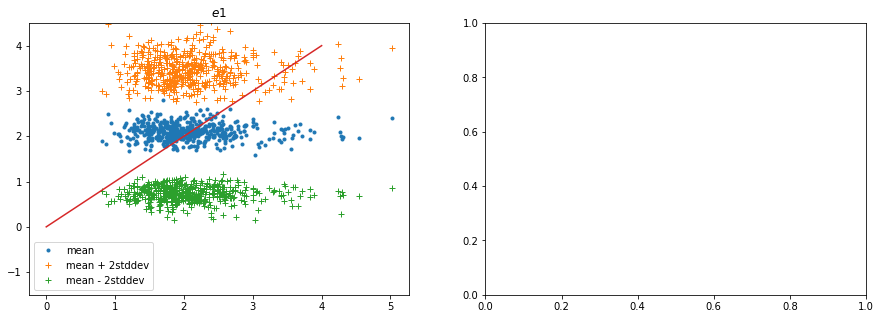

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(validation_labels, out.mean().numpy()[:], '.', label = 'mean')
axes[0].plot(validation_labels, out.mean().numpy()[:]+ 2*out.stddev().numpy()[:], '+', label = 'mean + 2stddev')
axes[0].plot(validation_labels, out.mean().numpy()[:]- 2*out.stddev().numpy()[:], '+', label = 'mean - 2stddev')
x = np.linspace(0,4)
axes[0].plot(x, x)
axes[0].legend()
axes[0].set_ylim(-1.5,4.5)
axes[0].set_title('$e1$')


Text(0.5, 1.0, '$e2$')

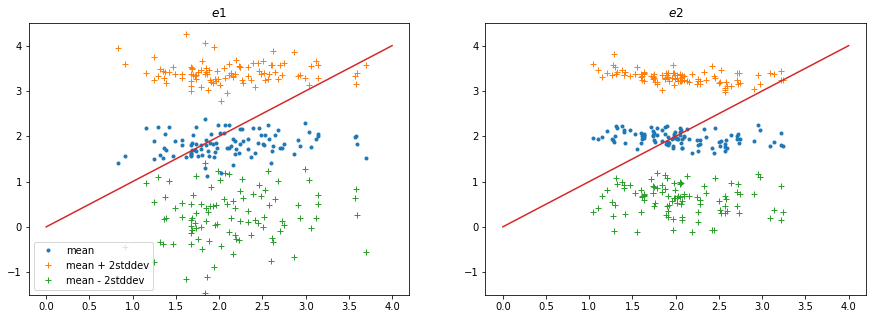

In [209]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(test[1][:,0], out.mean().numpy()[:,0], '.', label = 'mean')
axes[0].plot(test[1][:,0], out.mean().numpy()[:,0]+ 2*out.stddev().numpy()[:,0], '+', label = 'mean + 2stddev')
axes[0].plot(test[1][:,0], out.mean().numpy()[:,0]- 2*out.stddev().numpy()[:,0], '+', label = 'mean - 2stddev')
x = np.linspace(0,4)
axes[0].plot(x, x)
axes[0].legend()
axes[0].set_ylim(-1.5,4.5)
axes[0].set_title('$e1$')

axes[1].plot(test[1][:,1], out.mean().numpy()[:,1], '.', label = 'mean')
axes[1].plot(test[1][:,1], out.mean().numpy()[:,1]+ 2*out.stddev().numpy()[:,1], '+', label = 'mean + 2stddev')
axes[1].plot(test[1][:,1], out.mean().numpy()[:,1]- 2*out.stddev().numpy()[:,1], '+', label = 'mean - 2stddev')
x = np.linspace(0,4)
axes[1].plot(x, x)
#plt.xlim(0,4)
axes[1].set_ylim(-1.5,4.5)
axes[1].set_title('$e2$')

N samplings for 100 images (one batch)

In [ ]:
N = 100
means = np.zeros((N,100))
stddevs = np.zeros((N,100))
outs = np.zeros((N,100))
for i in range (N):
    out = net(test[0])
    outs[i] = out[:,0].numpy()
    means[i] = out.mean().numpy()[:,0]
    stddevs[i] = out.stddev().numpy()[:,0]

In [ ]:
image_nb = 0

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(means[:,image_nb], bins = 20, label = 'means', ax = axes[0])
sns.distplot(means[:,image_nb] + stddevs[:,image_nb], bins = 20, label = 'mean + stddev', ax = axes[0])
sns.distplot(means[:,image_nb] - stddevs[:,image_nb], bins = 20, label = 'mean - stddev', ax = axes[0])
axes[0].axvline(test[1][image_nb,0], color = 'r')
axes[0].legend()
print(test[1][image_nb,0])

axes[1].imshow(test[0][image_nb,:,:,2])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i in range (len(means)):
    x = np.linspace(0,4, 1000)
    axes[0].plot(x, (1/(stddevs[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means[i,image_nb])/(2*stddevs[i,image_nb]**2))), color = 'grey', alpha = 0.3)
mean_means = np.mean(means[:,image_nb])
mean_stddevs = np.mean(stddevs[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].set_xlim(np.min(means[:,image_nb] - stddevs[:,image_nb]), np.max(means[:,image_nb] + stddevs[:,image_nb]))
axes[0].axvline(test[1][image_nb,0], color = 'r')

axes[1].imshow(test[0][image_nb,:,:,2])

In [ ]:
sns.distplot(outs[:,image_nb], bins = 20, label = 'means')

In [ ]:
image_nb = 1

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(means[:,image_nb], bins = 20, label = 'means', ax = axes[0])
sns.distplot(means[:,image_nb] + stddevs[:,image_nb], bins = 20, label = 'mean + stddev', ax = axes[0])
sns.distplot(means[:,image_nb] - stddevs[:,image_nb], bins = 20, label = 'mean - stddev', ax = axes[0])
axes[0].axvline(test[1][image_nb,0], color = 'r')
axes[0].legend()
print(test[1][image_nb,0])

axes[1].imshow(test[0][image_nb,:,:,2])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i in range (len(means)):
    x = np.linspace(0,4, 1000)
    axes[0].plot(x, (1/(stddevs[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means[i,image_nb])/(2*stddevs[i,image_nb]**2))), color = 'grey', alpha = 0.3)
mean_means = np.mean(means[:,image_nb])
mean_stddevs = np.mean(stddevs[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].set_xlim(np.min(means[:,image_nb] - stddevs[:,image_nb]), np.max(means[:,image_nb] + stddevs[:,image_nb]))
axes[0].axvline(test[1][image_nb,0], color = 'r')

axes[1].imshow(test[0][image_nb,:,:,2])

In [ ]:
sns.distplot(means_dvar[:,0], bins = 20)